# Evaluation pipeline

## 0 Imports and Constants

In [16]:
import sys
import os

# Füge das übergeordnete Verzeichnis zu sys.path hinzu
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, parent_dir)

In [17]:
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import seaborn as sns
from copy import deepcopy as dc

from utilities import split_data_into_sequences, load_sequential_time_series, reconstruct_sequential_data, Scaler, extract_features_and_targets_reg
from visual_evaluation import visualize
from predictive_evaluation import predictive_evaluation

In [18]:
DATA_FOLDER = Path("../data")
REAL_DATA_FOLDER = DATA_FOLDER / "real"
SYNTHETIC_DATA_FOLDER = DATA_FOLDER / "synthetic"
BENCHMARK = False

## 1 Load and Visualize Data

### Ways of loading data
- Laden der Originaldaten: als pd dataframe 
- Laden der synthetischen, sequentiellen Daten: als np array (GAN, (V)AE)
- Laden der synthetischen, sequentiellen Daten: als pd dataframe (brownian, algorithmit)

In [19]:
# possible types: 'timegan_lstm', 'timegan_gru', 'jitter', 'timewarp', 'autoencoder'
syn_data_type = 'autoencoder'

In [20]:
# Load real time series
data_real_df = pd.read_csv(REAL_DATA_FOLDER/'metro_interstate_traffic_volume_label_encoded_no_categorical.csv')
data_real_numpy = dc(data_real_df).to_numpy()

if syn_data_type == 'timegan_lstm':
    # load sequential data (which should already be scaled)
    data_syn_numpy = load_sequential_time_series(SYNTHETIC_DATA_FOLDER/'mitv_28499_12_5_lstm_unscaled.csv', shape=(28499, 12, 5))

elif syn_data_type == 'timegan_gru':
    data_syn_numpy = load_sequential_time_series(SYNTHETIC_DATA_FOLDER/'mitv_28499_12_5_gru_unscaled.csv', shape=(28499, 12, 5))

elif syn_data_type == 'autoencoder':
    data_syn_numpy = load_sequential_time_series(SYNTHETIC_DATA_FOLDER/'mitv_28478_12_5_autoencoder_unscaled.csv', shape=(28478, 12, 5))

elif syn_data_type == 'jitter':
    jitter_factor = 0.1
    data_syn_df = pd.read_csv(SYNTHETIC_DATA_FOLDER/f'mitv_jittered_{str(jitter_factor).replace(".", "")}.csv')
    data_syn_numpy = dc(data_syn_df).to_numpy()

elif syn_data_type == 'timewarp':
    data_syn_df = pd.read_csv(SYNTHETIC_DATA_FOLDER/f'mitv_time_warped.csv')
    data_syn_numpy = dc(data_syn_df).to_numpy()

In [21]:
df = pd.DataFrame(data_syn_numpy.reshape(-1, data_syn_numpy.shape[-1]), columns=data_real_df.columns)
df.describe()

,traffic_volume,temp,rain_1h,snow_1h,clouds_all
count,341988.000000,341988.000000,341988.000000,341988.000000,341988.000000
mean,3223.797936,282.704303,0.086439,0.000249,39.871618
std,1943.974204,12.922822,0.321004,0.000466,39.339560
min,41.627638,250.083873,0.000008,0.000000,0.016394
25%,1152.987320,270.511312,0.000130,0.000002,4.172619
50%,3608.409516,285.328962,0.000575,0.000006,15.465574
75%,5010.047921,293.711888,0.037928,0.000324,87.893841
max,7076.619110,305.881726,12.279954,0.004205,97.951007


In [22]:
data_real_df.describe()

,traffic_volume,temp,rain_1h,snow_1h,clouds_all
count,28511.00000,28511.000000,28511.000000,28511.000000,28511.000000
mean,3313.74238,282.688768,0.061611,0.000250,42.122795
std,1971.53206,12.367361,0.678185,0.008298,39.316195
min,0.00000,243.390000,0.000000,0.000000,0.000000
25%,1289.00000,273.480000,0.000000,0.000000,1.000000
50%,3507.00000,284.550000,0.000000,0.000000,40.000000
75%,4948.00000,292.790000,0.000000,0.000000,90.000000
max,7280.00000,310.070000,42.000000,0.510000,100.000000


## 2 Train and Test Baseline Model

### Set Hyperparameters and Features

In [23]:
hyperparameters = {
    "seq_len": 12,
    "lr": 0.0001,
    "batch_size": 32,
    "hidden_size": 4,
    "num_layers": 1,
    "num_evaluation_runs": 10,
    "num_epochs": 200,
    "device": 'cuda' if torch.cuda.is_available() else 'cpu'
}

In [24]:
results = predictive_evaluation(data_real_numpy, data_syn_numpy, hyperparameters, include_baseline=True, verbose=True)

HYPERPARAMETERS:
seq_len :  12
lr :  0.0001
batch_size :  32
hidden_size :  4
num_layers :  1
num_evaluation_runs :  10
num_epochs :  200
device :  cpu
Synthetic Data is sequential: True
Shape of the data after splitting into sequences: (22797, 12, 5)
Shape of the data after splitting into sequences: (2841, 12, 5)
Shape of the data after splitting into sequences: (2840, 12, 5)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
Training Loss: 0.24119424119591712
Training Loss: 0.18401481933891772
Training Loss: 0.1334337119758129
Validation Loss: 0.09592090019684159
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.09178646761924028
Training Loss: 0.08010064935311675
Training Loss: 0.07497216440737248
Validation Loss: 0.06612016704310192
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.07067093627527356
Training Loss: 0.0698295515216887
Training Loss: 0.06818561980500817
Validation Loss: 0.060983331308940826
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.06453764336183668
Training Loss: 0.0636335587874055
Training Loss: 0.06181022485718131
Validation Loss: 0.05544982892408799
Validation Accuracy: 0.0
**************************************************
Epoch: 5
Training Loss: 0.05827494002878666
Training Loss: 0.05715131191536784
Training Loss: 

/Users/arneallwardt/Documents/-Studium/Bachelorarbeit/time_series_data_augmentation/data_evaluation/predictive_evaluation.py:247: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame([{'Model': evaluation_method, 'Metric': 'MAE', 'Error': mae}])], ignore_index=True)
 10%|█         | 1/10 [03:39<32:59, 219.99s/it]

Training Loss: 0.006061403870116919
Validation Loss: 0.0029858922980872268
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.32372913755476473
Training Loss: 0.2285681564733386
Training Loss: 0.14147492986172439
Validation Loss: 0.08669047710600863
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.08147218683734536
Training Loss: 0.07033737940713763
Training Loss: 0.06613560577854515
Validation Loss: 0.05831594526600302
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.06214642688632011
Training Loss: 0.06115062309429049
Training Loss: 0.059181722458451984
Validation Loss: 0.051761798016475825
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.054877752512693403
Training Loss: 0.05341976620256901
Training Loss: 0.05088425261899829
Validation Loss: 0.04442134154228012
Validation Accu

 20%|██        | 2/10 [07:21<29:25, 220.74s/it]

Training Loss: 0.005625752561027184
Validation Loss: 0.0026586911669838125
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.7776858684420586
Training Loss: 0.6394009041786194
Training Loss: 0.48389123752713203
Validation Loss: 0.299958744745576
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.28380622252821924
Training Loss: 0.16297036334872245
Training Loss: 0.09363886298611761
Validation Loss: 0.0628881487534957
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.07128321465104819
Training Loss: 0.06906697073951364
Training Loss: 0.0669786612316966
Validation Loss: 0.05948877723866634
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.0643445204012096
Training Loss: 0.06389511831104755
Training Loss: 0.062428492903709415
Validation Loss: 0.056347157889872455
Validation Accuracy: 0

 30%|███       | 3/10 [10:57<25:31, 218.82s/it]

Validation Loss: 0.003268100510958289
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.22902838714420795
Training Loss: 0.18422583863139153
Training Loss: 0.14056444451212882
Validation Loss: 0.11308177669396562
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.10263885611668229
Training Loss: 0.08599714836105704
Training Loss: 0.07337293667718768
Validation Loss: 0.06667721978901478
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.06708978913724423
Training Loss: 0.06556079521775246
Training Loss: 0.06341423138976097
Validation Loss: 0.0598102928965949
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.06144554316997528
Training Loss: 0.06059543294832111
Training Loss: 0.05828909568488598
Validation Loss: 0.05375778407193302
Validation Accuracy: 0.0
******************************

 40%|████      | 4/10 [14:40<22:00, 220.16s/it]

Training Loss: 0.006535794720402919
Validation Loss: 0.0035838104609211678
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.2245950670540333
Training Loss: 0.16661962497979402
Training Loss: 0.11112792067229747
Validation Loss: 0.0821417931760295
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.07762112097814679
Training Loss: 0.07380062872543931
Training Loss: 0.07176680712029337
Validation Loss: 0.06785346730873826
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.06931640706956387
Training Loss: 0.06850778741762042
Training Loss: 0.06656325103715062
Validation Loss: 0.06253626180833645
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.06391947336494923
Training Loss: 0.0628625843860209
Training Loss: 0.060676695797592405
Validation Loss: 0.05679146447375919
Validation Accuracy

 50%|█████     | 5/10 [18:19<18:20, 220.05s/it]

Epoch: 1
Training Loss: 0.17026663973927497
Training Loss: 0.1345571557804942
Training Loss: 0.10827182162553071
Validation Loss: 0.09111161571875047
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.09075560873374343
Training Loss: 0.08448251381516457
Training Loss: 0.07954296536743641
Validation Loss: 0.0734803272683299
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.07617809752002358
Training Loss: 0.07542094480246306
Training Loss: 0.07382329169660806
Validation Loss: 0.06912757615359981
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.07145622074604034
Training Loss: 0.07090886685997248
Training Loss: 0.06935038914903999
Validation Loss: 0.06500985465022956
Validation Accuracy: 0.0
**************************************************
Epoch: 5
Training Loss: 0.06694469355046749
Training Loss: 0.06612210117280483
Training Loss: 

 50%|█████     | 5/10 [21:15<21:15, 255.16s/it]

Training Loss: 0.006818693149834871


KeyboardInterrupt: 

In [ ]:
results.shape

(80, 3)

In [ ]:
results.to_csv(DATA_FOLDER / f"results/results_{syn_data_type}_{hyperparameters['num_epochs']}_{hyperparameters['num_evaluation_runs']}.csv", index=False)

In [ ]:
mse_results = results.loc[results['Metric'] == 'MSE']
mae_results = results.loc[results['Metric'] == 'MAE']

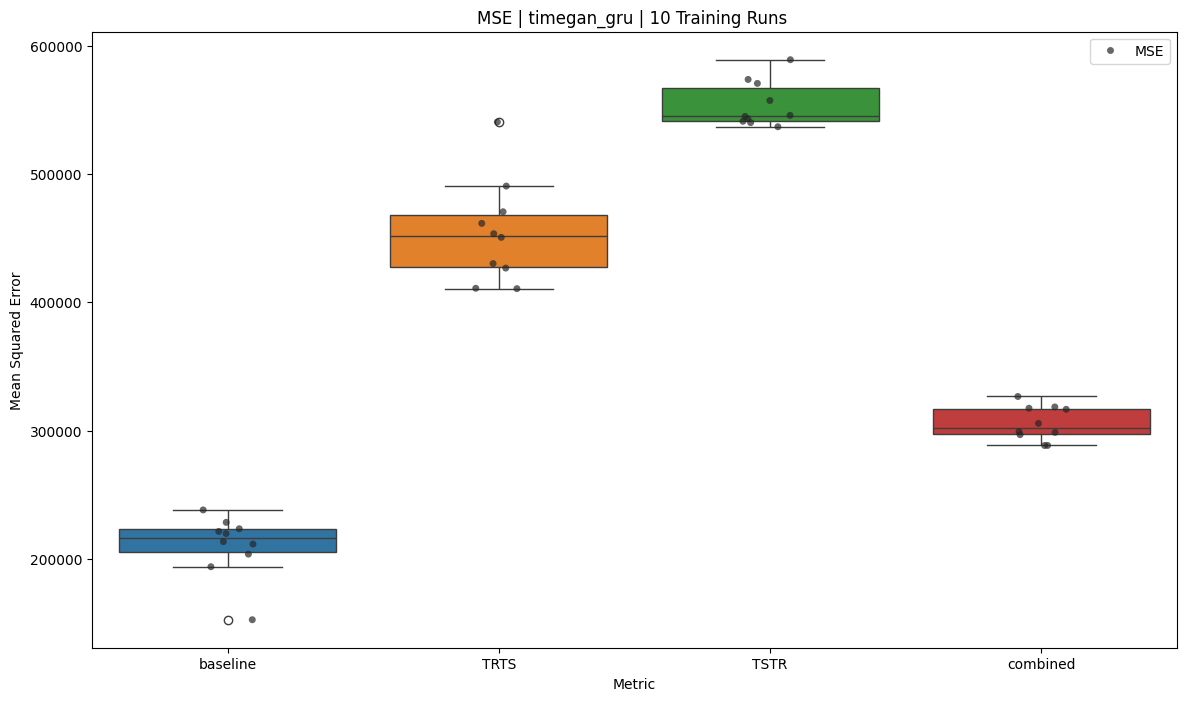

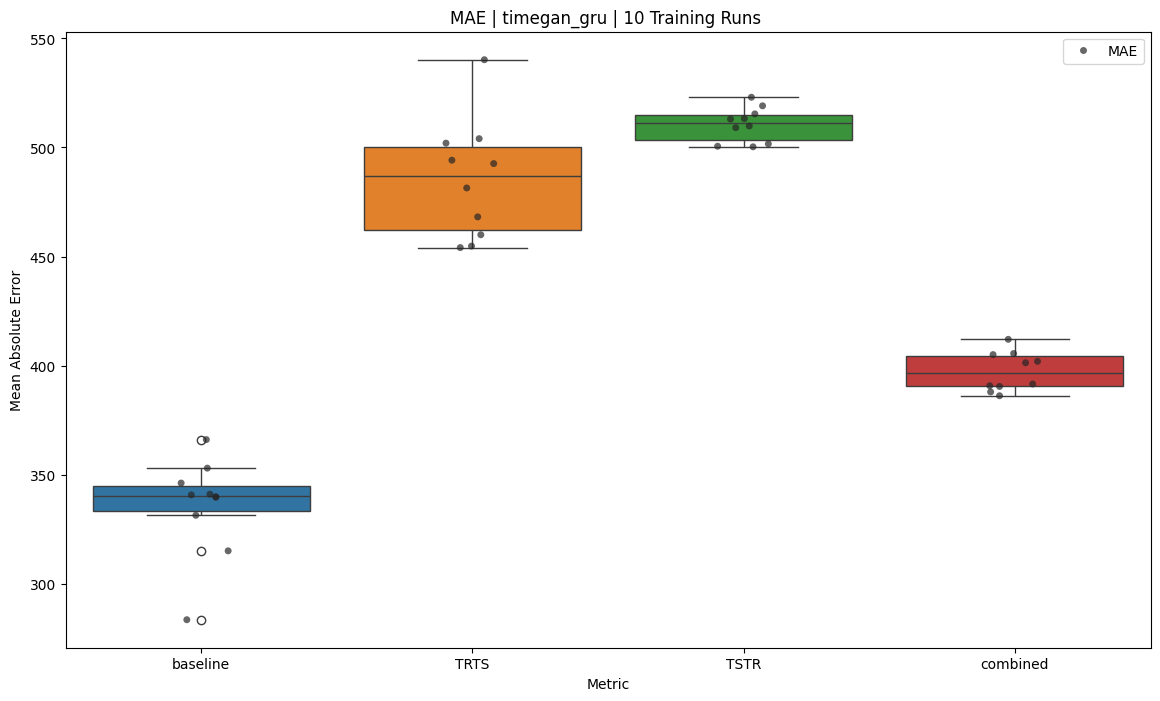

In [ ]:
plt.figure(figsize=(14, 8))
sns.boxplot(x='Model', y='Error', hue='Model', data=mse_results)
sns.stripplot(x='Model', y='Error', hue='Metric', data=mse_results, dodge=True, jitter=True, palette='dark:black', alpha=0.7)
plt.ylabel('Mean Squared Error')
plt.xlabel('Metric')
plt.title(f'MSE | {syn_data_type} | {hyperparameters["num_evaluation_runs"]} Training Runs {" | jitter factor = " + str(jitter_factor) if syn_data_type == "jitter" else ""}')
plt.legend()

plt.figure(figsize=(14, 8))
sns.boxplot(x='Model', y='Error', hue='Model', data=mae_results)
sns.stripplot(x='Model', y='Error', hue='Metric', data=mae_results, dodge=True, jitter=True, palette='dark:black', alpha=0.7)
plt.ylabel('Mean Absolute Error')
plt.xlabel('Metric')
plt.title(f'MAE | {syn_data_type} | {hyperparameters["num_evaluation_runs"]} Training Runs {" | jitter factor = " + str(jitter_factor) if syn_data_type == "jitter" else ""}')
plt.legend()

## 3 Visualize Synthetic vs Real Data

In [ ]:
# split data before feeding into visual evaluation
data_real_seq = split_data_into_sequences(data_real_numpy, seq_len=hyperparameters['seq_len'], shuffle_data=True)

if data_syn_numpy.ndim == 3:
    data_syn_seq = data_syn_numpy
else:
    data_syn_seq = split_data_into_sequences(data_syn_numpy, seq_len=hyperparameters['seq_len'], shuffle_data=True)

Shape of the data after splitting into sequences: (28500, 12, 5)


Preprocessing data. Shape: (28500, 12, 5)
Data has been preprocessed. Shape: (1000, 60)


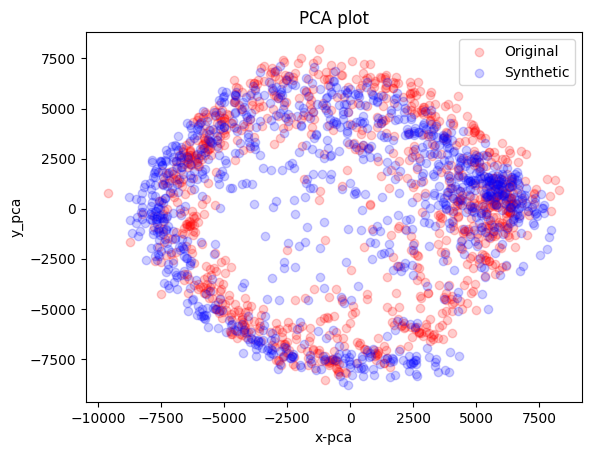

Preprocessing data. Shape: (28500, 12, 5)
Data has been preprocessed. Shape: (1000, 60)
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.001s...
[t-SNE] Computed neighbors for 2000 samples in 0.175s...


/Users/arneallwardt/Documents/-Studium/Bachelorarbeit/time_series_data_augmentation/time_series_data_augmentation_venv/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 1177.287918
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.165985
[t-SNE] KL divergence after 300 iterations: 1.160892


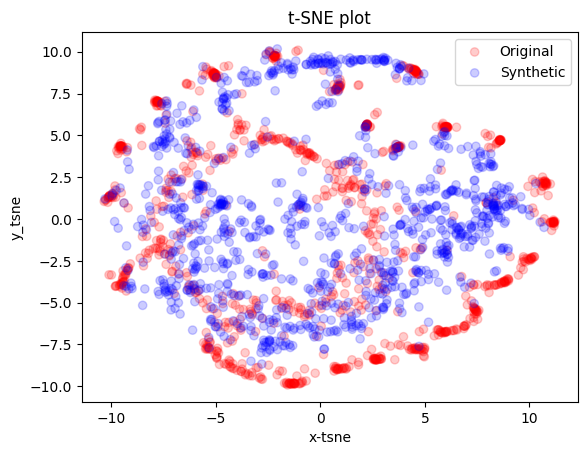

In [ ]:
visualize(data_real_seq, data_syn_seq, metric='pca')
visualize(data_real_seq, data_syn_seq, metric='tsne')

### Beispielaussage:
PCA-Analyse von Realen und Synthetischen Daten
Um die Ähnlichkeit zwischen den realen und synthetischen Daten zu bewerten, wurde eine Principal Component Analysis (PCA) durchgeführt. Die PCA reduziert die Dimensionalität der Daten und projiziert sie auf eine zweidimensionale Ebene, wobei die Hauptkomponenten beibehalten werden, die den größten Teil der Varianz erklären.

Abbildung X zeigt den PCA-Plot der realen (rote Punkte) und synthetischen Daten (blaue Punkte). Die folgenden Beobachtungen können gemacht werden:

Verteilung und Clusterbildung:

Die roten Punkte, die die realen Daten repräsentieren, sind in einem spezifischen Bereich konzentriert.
Die blauen Punkte, die die synthetischen Daten darstellen, zeigen eine größere Verteilung und decken einen breiteren Bereich ab.
Ähnlichkeit und Unterschiede:

Die Tatsache, dass die synthetischen Daten eine größere Variabilität aufweisen, könnte darauf hinweisen, dass sie eine breitere Vielfalt an Mustern generieren.
Die Cluster der realen und synthetischen Daten überlappen sich teilweise, was darauf hindeutet, dass die synthetischen Daten einige der Eigenschaften der realen Daten gut nachahmen. Allerdings gibt es auch Bereiche, in denen die synthetischen Daten stark von den realen Daten abweichen, was auf Unterschiede in den zugrunde liegenden Verteilungen hinweist.
Schlussfolgerung:

Die PCA-Analyse zeigt, dass die synthetischen Daten in gewissem Maße die Struktur der realen Daten einfangen, jedoch eine größere Variabilität aufweisen.
Weitere Untersuchungen und Anpassungen am Generierungsprozess der synthetischen Daten könnten notwendig sein, um deren Genauigkeit und Übereinstimmung mit den realen Daten zu verbessern.